In [1]:
import warnings
warnings.filterwarnings('ignore')
from dataclasses import replace
import pandas as pd
import yfinance as yf
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import math
sns.set_style('whitegrid')
########input
startday = datetime.date.today() - datetime.timedelta(days=260*7)
###############

In [2]:
data = pd.read_html('https://portal.settrade.com/C13_MarketSummary.jsp?detail=SET100')
#data = data[2].rename(columns={'หลักทรัพย์':'ticker'})
data = list(data[3]['หลักทรัพย์'])
#data = data['ticker']
name = []
for i in range(len(data)):
  name.append(f"{data[i]}.BK")

In [163]:
marketdata = yf.download(name, start=startday, end="{}".format(datetime.date.today()))
marketdata= marketdata.rename(columns={'Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})
def tr(data):
        data[('previous_close',i)] = data[('close',i)].shift(1)
        data[('high-low',i)] = abs(data[('high',i)] - data[('low',i)])
        data[('high-pc',i)] = abs(data[('high',i)] - data[('previous_close',i)])
        data[('low-pc',i)] = abs(data[('low',i)] - data[('previous_close',i)])
        data[('252highest',i)] = data[('high',i)].rolling(252).max()
        data[('tr',i)]=data[[('high-low',i), ('high-pc',i), ('low-pc',i)]].max(axis=1)
def atr(data, period):
    for i in data[('close',i)].columns:
        data[('previous_close',i)] = data[('close',i)].shift(1)
        data[('high-low',i)] = abs(data[('high',i)] - data[('low',i)])
        data[('high-pc',i)] = abs(data[('high',i)] - data[('previous_close',i)])
        data[('low-pc',i)] = abs(data[('low',i)] - data[('previous_close',i)])
        data[('252highest',i)] = data[('high',i)].rolling(252).max()
        data[('tr',i)]=data[[('high-low',i), ('high-pc',i), ('low-pc',i)]].max(axis=1)
        data[('atr',i)] = data[('tr',i)].rolling(period).mean()
    return data
def supertrend(df, period=10, atr_multiplier=4, traderisk=0.01):
    for i in df['close'].columns:
        df[('previous_close',i)] = df[('close',i)].shift(1)
        df[('high-low',i)] = abs(df[('high',i)] - df[('low',i)])
        df[('high-pc',i)] = abs(df[('high',i)] - df[('previous_close',i)])
        df[('low-pc',i)] = abs(df[('low',i)] - df[('previous_close',i)])
        df[('252highest',i)] = df[('high',i)].rolling(252).max()
        df[('tr',i)]=df[[('high-low',i), ('high-pc',i), ('low-pc',i)]].max(axis=1)
        df[('atr',i)] = df[('tr',i)].rolling(period).mean()
        df[('hl2',i)] = (df[('high',i)] + df[('low',i)]) / 2
        df[('upperband',i)] = df[('hl2',i)] + (atr_multiplier * df[('atr',i)])
        df[('lowerband',i)] = df[('hl2',i)] - (atr_multiplier * df[('atr',i)])
        df[('in_uptrend',i)] = True
        df[('pos',i)] = np.zeros(len(df))
        df[('trade',i)] = np.zeros(len(df))
        df[('pct_change',i)] = df[('close',i)].pct_change()
        df[('ln_ret',i)] = np.log(df[('close',i)]/df[('close',i)].shift(1))
        df[('SMA50',i)] = df[('close',i)].rolling(50).mean()
        df[('SMA150',i)] = df[('close',i)].rolling(150).mean()
        for current in range(1, len(df.index)):
            previous = current - 1

            if df[('close',i)][current] > df[('upperband',i)][previous] and df[('close',i)][previous]>df[('SMA50',i)][previous] and df[('close',i)][previous]>df[('SMA150',i)][previous] and df[('atr',i)][previous]>df[('atr',i)][previous-50]:
                df[('in_uptrend',i)][current] = True
                pos = traderisk/((df[('close',i)][current]-df[('lowerband',i)][previous])/df[('close',i)][current])
                usepose = pos if pos<1 else 0
                df[('pos',i)][current] = usepose
                df[('trade',i)][current] = df[('trade',i)][previous]
            elif df[('close',i)][current] < df[('lowerband',i)][previous]:
                df[('in_uptrend',i)][current] = False
                df[('pos',i)][current] = 0
                df[('trade',i)][current] = df[('trade',i)][previous] +1
            else:
                df[('trade',i)][current] = df[('trade',i)][previous]
                df[('in_uptrend',i)][current] = df[('in_uptrend',i)][previous]
                df[('pos',i)][current] = df[('pos',i)][previous]
                if df[('in_uptrend',i)][current] and df[('lowerband',i)][current] < df[('lowerband',i)][previous]:
                    df[('lowerband',i)][current] = df[('lowerband',i)][previous]
                if not df[('in_uptrend',i)][current] and df[('upperband',i)][current] > df[('upperband',i)][previous]:
                    df[('upperband',i)][current] = df[('upperband',i)][previous]
        df[('dailyret',i)] = (df[('pos',i)]*df[('ln_ret',i)])
        df[('stratret',i)] = (df[('in_uptrend',i)].fillna(0)*df[('ln_ret',i)].fillna(0))
        df[('stratret_mean',i)] = (df[('stratret',i)].fillna(0)*df[('pos',i)].fillna(0)).rolling(260).mean()*260
        df[('stdev',i)] = df[('stratret_mean',i)].fillna(0).rolling(260).std()
        df[('sharpe',i)] = df[('stratret_mean',i)]/df[('stdev',i)]
    return df

[*********************100%***********************]  100 of 100 completed


In [122]:
port = supertrend(marketdata)

In [164]:
test = port.copy()[['in_uptrend','sharpe','close','pct_change','lowerband','pos','trade','stratret','dailyret','stdev','ln_ret']]

In [165]:
import matplotlib.pyplot as plt
import quantstats as qs
%matplotlib inline

In [166]:
sharpe = pd.DataFrame(test['sharpe'].loc[test.index[len(test)-1]].rename('sharpe'))
trade = pd.DataFrame(test['trade'].loc[test.index[len(test)-1]].rename('trade'))
pos  = pd.DataFrame(test['pos'].loc[test.index[len(test)-1]].rename('pos'))
for i in range(len(pos)):
    if pos['pos'][i]==0 :
        pos['pos'][i] = np.NaN
close  = pd.DataFrame(test['close'].loc[test.index[len(test)-1]].rename('close'))
stratret  = pd.DataFrame(test['stratret'].loc[test.index[len(test)-1]].rename('stratret'))
stdev = pd.DataFrame(test['stdev'].loc[test.index[len(test)-1]].rename('stdev'))

In [167]:
weights = test['pos'].iloc[len(test)-1][[output.index[0]]]
log_ret = test['ln_ret'].iloc[:len(test)-260][[output.index[0]]].dropna()
vol_arr= np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*260, weights)))
ret_arr = np.sum( (log_ret.iloc[:len(test)-260].mean() * weights * 260))
sharpe_arr = ret_arr/vol_arr

In [168]:
output = pd.concat([pos,close,trade,stratret,stdev],axis=1)
output['avgppt'] = output['stratret']/output['trade']
output['sharpe'] = output['stratret']/output['stdev']
output = output.sort_values(by=['sharpe'],ascending=False).dropna()

In [169]:
output['sharpe'][0] = sharpe_arr

In [170]:
output

,pos,close,trade,stratret,stdev,avgppt,sharpe
OSP.BK,0.095238,31.500000,4.0,0.032261,0.002331,0.008065,0.174924
ORI.BK,0.087805,11.800000,6.0,0.017094,0.005938,0.002849,2.878663
PLANB.BK,0.055556,9.200000,8.0,0.010929,0.005010,0.001366,2.181533
CENTEL.BK,0.104717,55.000000,7.0,0.009132,0.005761,0.001305,1.585361
STA.BK,0.072575,23.799999,6.0,0.008439,0.005635,0.001406,1.497644
DTAC.BK,0.100538,52.250000,9.0,0.014458,0.009674,0.001606,1.494481
IRPC.BK,0.123200,3.080000,3.0,0.006515,0.004486,0.002172,1.452262
CHG.BK,0.087719,3.960000,6.0,0.010152,0.011091,0.001692,0.915383
TCAP.BK,0.114286,42.750000,11.0,0.005865,0.007351,0.000533,0.797873
GULF.BK,0.152113,54.250000,9.0,0.004619,0.007510,0.000513,0.615050


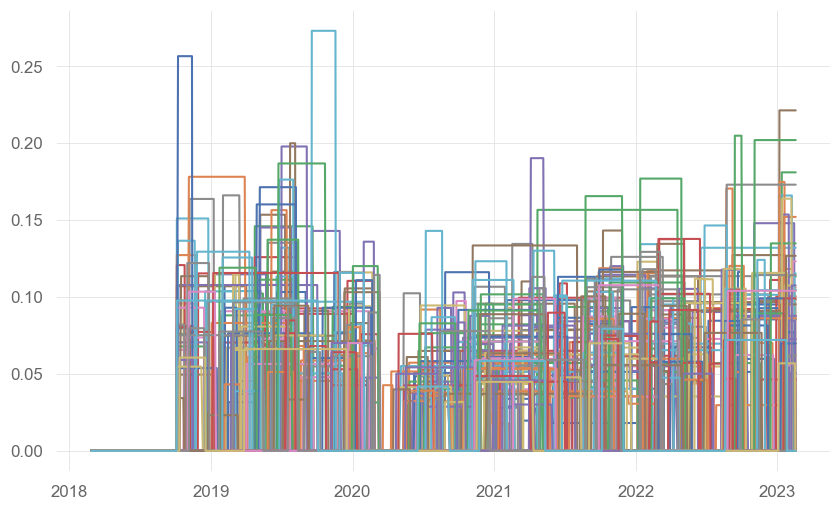

In [171]:
plt.figure(figsize=(10,6))
plt.plot(test['pos'])
plt.show()

In [172]:
def genoutput(output,portfolioticker):
    for i in range(len(output.index)):
        weights = test['pos'].iloc[len(test)-1][portfolioticker+[output.index[i]]]
        log_ret = test['stratret'].iloc[len(test)-260:][portfolioticker+[output.index[i]]].dropna()
        vol_arr= np.sqrt(np.dot(weights.T, np.dot(log_ret.cov()*252, weights)))
        ret_arr = np.sum( (log_ret.iloc[:len(test)-260].mean() * weights * 260))
        sharpe_arr = ret_arr/vol_arr
        output['sharpe'][i] = sharpe_arr
    output = output.sort_values(by=['sharpe'],ascending=False).dropna()
    return output,portfolioticker

In [173]:
def stockscan(output):
    pos = 0
    stock = []
    portfolioticker = []
    exptret = 0
    while pos + output['pos'][output.index[0]]<=1:
        stock.append({'Ticker : {} , Hold portion : {} , Expected Sharpe : {}'.format(output.index[0],output['pos'][output.index[0]],output['sharpe'][output.index[0]])})
        portfolioticker.append(output.index[0])
        pos = pos+output['pos'][output.index[0]]
        output = output.drop(index=output.index[0])
        output,portfolioticker = genoutput(output,portfolioticker)
    return stock,pos,portfolioticker

In [174]:
stock,position,portfolioticker = stockscan(output)

In [176]:
stock

[{'Ticker : OSP.BK , Hold portion : 0.09523809523809527 , Expected Sharpe : 0.17492396830134876'},
 {'Ticker : DELTA.BK , Hold portion : 0.02968065122103945 , Expected Sharpe : 1.4158760706546412'},
 {'Ticker : BBL.BK , Hold portion : 0.13203883495145635 , Expected Sharpe : 2.0795188453028244'},
 {'Ticker : STA.BK , Hold portion : 0.07257524042476071 , Expected Sharpe : 2.268217454540042'},
 {'Ticker : TCAP.BK , Hold portion : 0.1142857142857143 , Expected Sharpe : 2.366206248957403'},
 {'Ticker : HANA.BK , Hold portion : 0.04637305699481866 , Expected Sharpe : 2.4542743218153285'},
 {'Ticker : CENTEL.BK , Hold portion : 0.10471698113207552 , Expected Sharpe : 2.517414651768045'},
 {'Ticker : BGRIM.BK , Hold portion : 0.08742138364779871 , Expected Sharpe : 2.5513775640838494'},
 {'Ticker : TISCO.BK , Hold portion : 0.2020725388601035 , Expected Sharpe : 2.5505994866174158'},
 {'Ticker : CHG.BK , Hold portion : 0.08771932227827212 , Expected Sharpe : 2.5148789755836507'}]

In [1]:
plt.figure(figsize=(10,6))
plt.plot((test['pos'][portfolioticker]*test['stratret'][portfolioticker]).iloc[len(test)-260:].sum(axis=1).cumsum())
plt.title('Portfolio')
plt.show()

NameError: name 'plt' is not defined

-0.23822546578516585